# Importing the Packages

In [1]:
# !pip3 install -r requirements.txt

In [2]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as  np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from category_encoders.leave_one_out import LeaveOneOutEncoder

# Data Importing

Import the data

In [41]:
restaurants = pd.read_csv('https://raw.githubusercontent.com/mohamad-selman/Meal-Prep-Time/main/restaurants.csv')
orders = pd.read_csv('https://raw.githubusercontent.com/mohamad-selman/Meal-Prep-Time/main/orders.csv')

Join (left outer join) orders and restaurants tables on 'restaurant_id' (the primary key)

In [4]:
data = orders.merge(restaurants, how='left', on='restaurant_id')

# Data Preprocessing 

Check if there is any missing value

In [5]:
data.isnull().sum(axis=0)

order_acknowledged_at    0
order_ready_at           0
order_value_gbp          0
restaurant_id            0
number_of_items          0
prep_time_seconds        0
country                  0
city                     0
type_of_food             0
dtype: int64

Convert 'order_acknowledged_at' and 'order_ready_at' to datetime format

In [6]:
for c in ['order_acknowledged_at', 'order_ready_at']:
  data[c] = pd.to_datetime(data[c])

Remove timezone

In [7]:
for c in ['order_acknowledged_at', 'order_ready_at']:
  data[c] = data[c].apply(lambda x: x.replace(tzinfo=None))

Extract month, hour, weekday, and monthday from order_acknowledged_at

In [8]:
data['order_ack_month'] = data['order_acknowledged_at'].dt.month
data['order_ack_hour'] = data['order_acknowledged_at'].dt.hour
data['order_ack_weekday'] = data['order_acknowledged_at'].dt.weekday
data['order_ack_monthday'] = data['order_acknowledged_at'].dt.day
data['order_ack_dayname'] = data['order_acknowledged_at'].dt.day_name()

## Removing Outliers

In [9]:
data.describe()

,order_value_gbp,restaurant_id,number_of_items,prep_time_seconds,order_ack_month,order_ack_hour,order_ack_weekday,order_ack_monthday
count,32394.000000,32394.000000,32394.000000,32394.000000,32394.000000,32394.000000,32394.000000,32394.000000
mean,26.547303,1290.555535,4.025715,1299.993857,6.000123,18.788325,3.123819,15.868463
std,19.263851,960.295504,2.392063,4404.573191,0.011112,3.066331,2.064561,8.604989
min,0.500000,3.000000,1.000000,0.000000,6.000000,0.000000,0.000000,1.000000
25%,16.700000,408.000000,3.000000,518.000000,6.000000,17.000000,1.000000,8.000000
50%,21.400000,1160.000000,3.000000,820.000000,6.000000,20.000000,3.000000,16.000000
75%,30.250000,2117.000000,5.000000,1227.000000,6.000000,21.000000,5.000000,23.000000
max,711.000000,3622.000000,38.000000,255499.000000,7.000000,23.000000,6.000000,30.000000


Max value is much larger than 75% percentile.
Fitting the model without removing the outliers leads to inaccurate predictions

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa4effc44d0>,
      dtype=object)

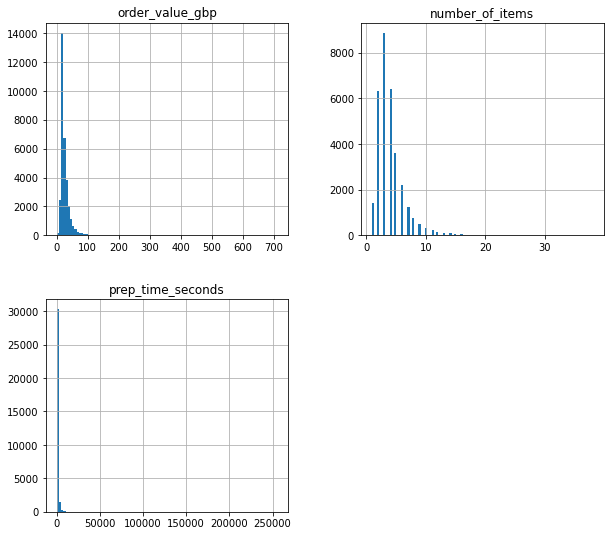

In [10]:
data.hist(column=['order_value_gbp', 'number_of_items', 'prep_time_seconds'], bins=100, figsize=(10, 9))

Use Interquartile Range (IQR) to find and drop the outliers

In [11]:
def drop_outliers(data, column):
  Q1 = data[column].quantile(0.25)
  Q3 = data[column].quantile(0.75)
  IQR = Q3 - Q1

  lower_limit = Q1 - 1.5 * IQR
  upper_limit = Q3 + 1.5 * IQR

  outliers = (data[column] < lower_limit) | (data[column] > upper_limit)
  return data[~outliers]

Drop the outliers

In [12]:
data = drop_outliers(data, 'prep_time_seconds')
data = drop_outliers(data, 'order_value_gbp')

In [13]:
data = data.reset_index().drop(columns=['index'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa4ef9f7b50>,
      dtype=object)

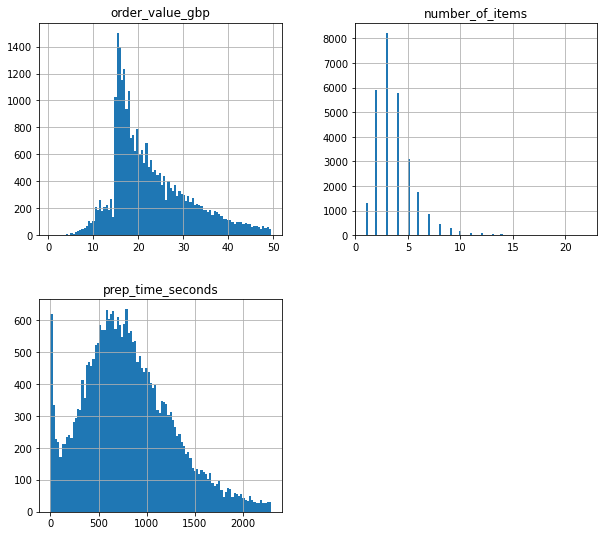

In [14]:
data.hist(column=['order_value_gbp', 'number_of_items', 'prep_time_seconds'], bins=100, figsize=(10, 9))

'number_of_items' was not trimmed to keep the model generalized (the model would be more accurate with orders with small number of items but less accurate on orders with large number of items)

# Data Visualisation

## Number of Orders by Weekday

Text(0, 0.5, 'Number of Orders')

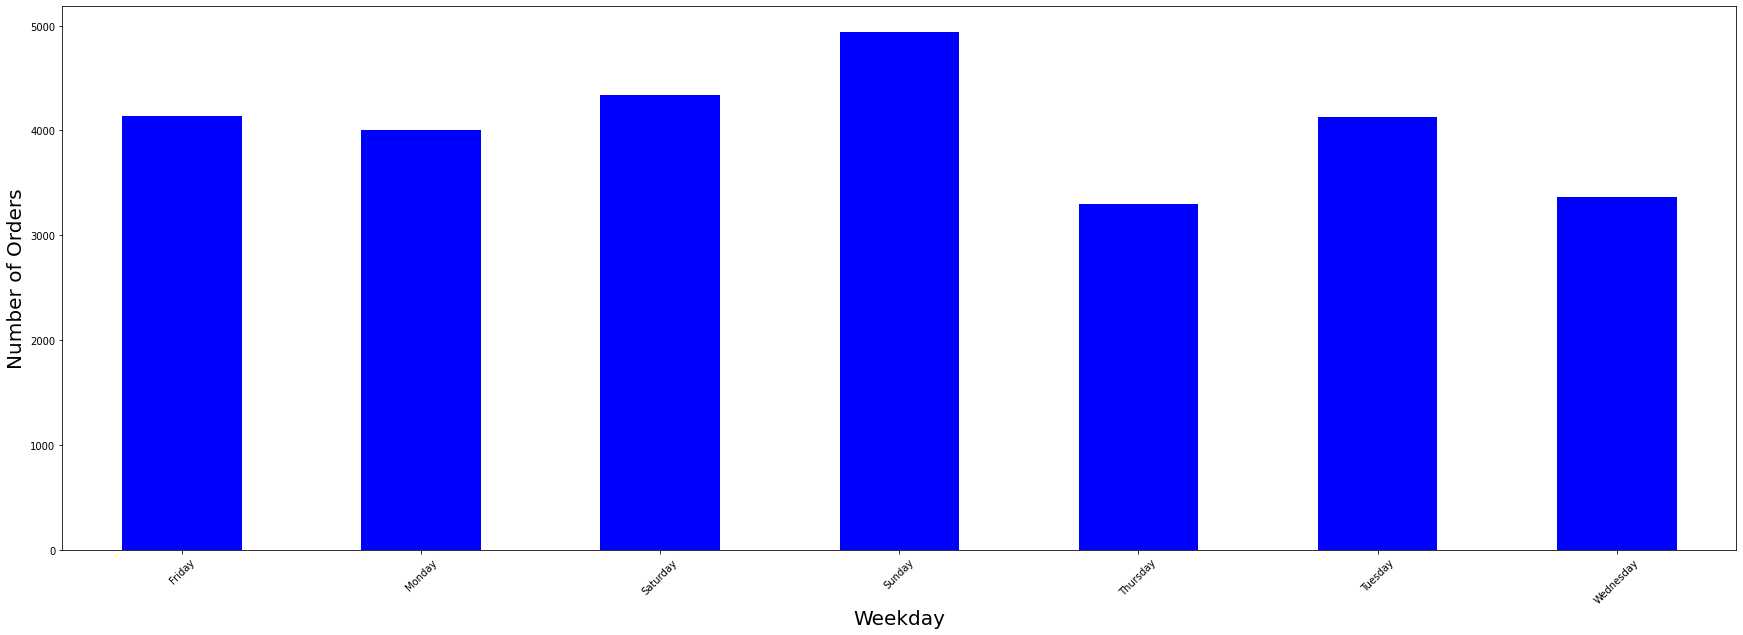

In [15]:
data.groupby([data.order_ack_dayname])\
  .order_acknowledged_at.count()\
  .plot(kind='bar', color='blue', figsize=(30, 10), rot=45)

plt.xlabel('Weekday', fontsize=20)
plt.ylabel('Number of Orders', fontsize=20)

Observation: Sundays have the highest number of orders

## Number of Orders by Hour

Text(0, 0.5, 'Number of Orders')

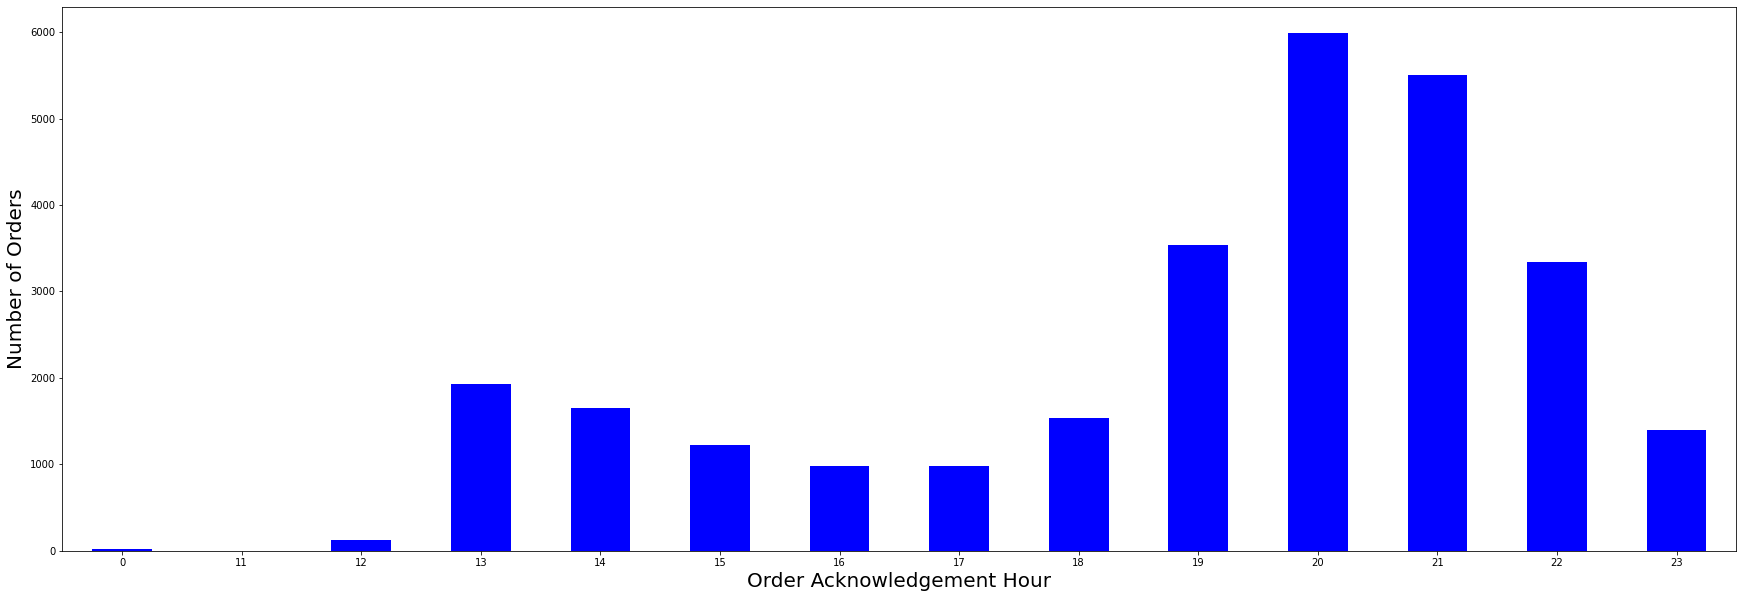

In [16]:
data.groupby([data.order_ack_hour])\
  .order_acknowledged_at.count()\
  .plot(kind='bar', color='blue', figsize=(30, 10), rot=0)

plt.xlabel('Order Acknowledgement Hour', fontsize=20)
plt.ylabel('Number of Orders', fontsize=20)

Observation: most of orders are placed between 7:00 pm to 10:00 pm

## Number of Orders by Country

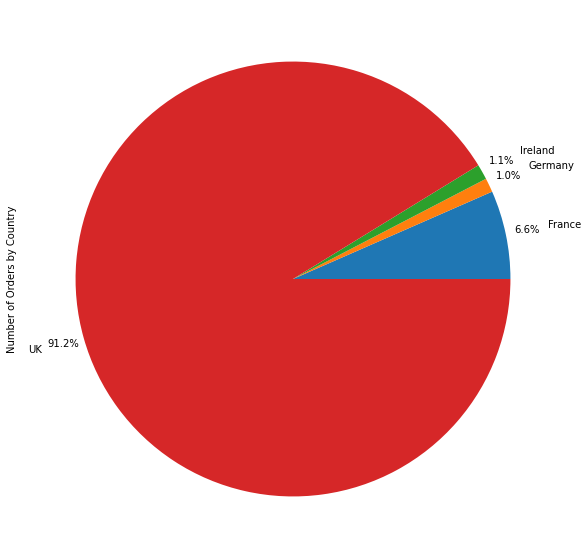

In [17]:
data.groupby([data.country])\
  .order_acknowledged_at.count()\
  .plot(kind='pie', figsize=(30, 10), autopct='%1.1f%%', pctdistance=1.1, labeldistance=1.2, label='Number of Orders by Country')

Observation : most of orders are in UK

## Number of Orders by Cuisine

Text(0, 0.5, 'Number of Orders')

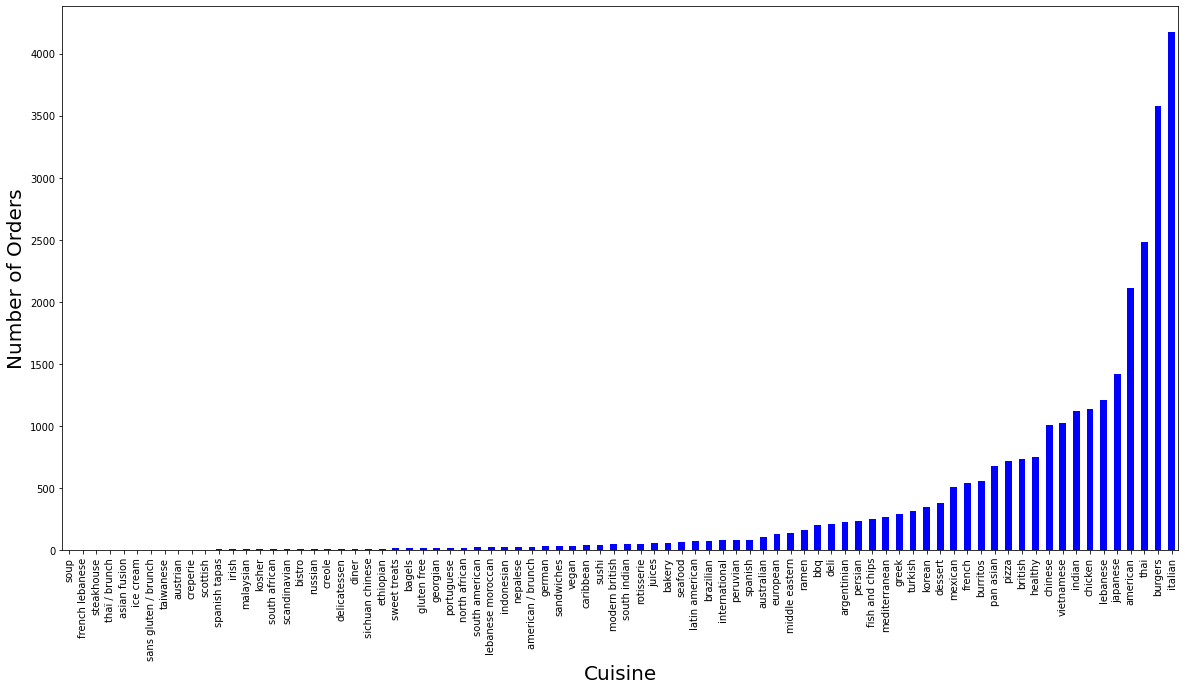

In [18]:
data.groupby([data.type_of_food])\
  .order_acknowledged_at.count()\
  .sort_values()\
  .plot(kind='bar', color='blue', figsize=(20, 10))

plt.xlabel('Cuisine', fontsize=20)
plt.ylabel('Number of Orders', fontsize=20)

Observation : Italian, Burgers, Thai, and American and japanese has been ordered the most

## Average Order Value by City

Text(0, 0.5, 'Average Order value in GBP')

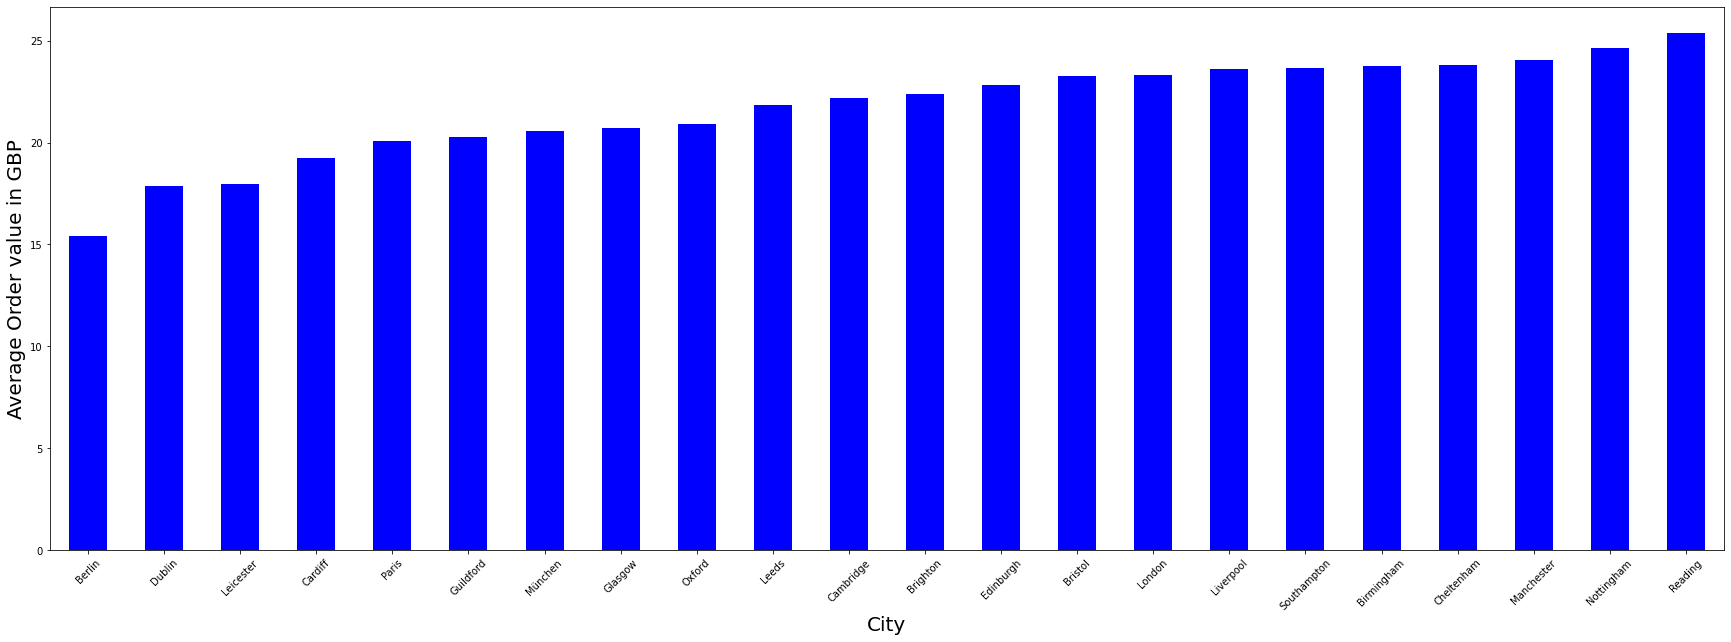

In [19]:
data.groupby([data.city])\
  .order_value_gbp.mean()\
  .sort_values()\
  .plot(kind='bar', color='blue', figsize=(30, 10), rot=45)

plt.xlabel('City', fontsize=20)
plt.ylabel('Average Order value in GBP', fontsize=20)

## Distribution of Order Values

Text(0.5, 0, 'Order Value in GBP')

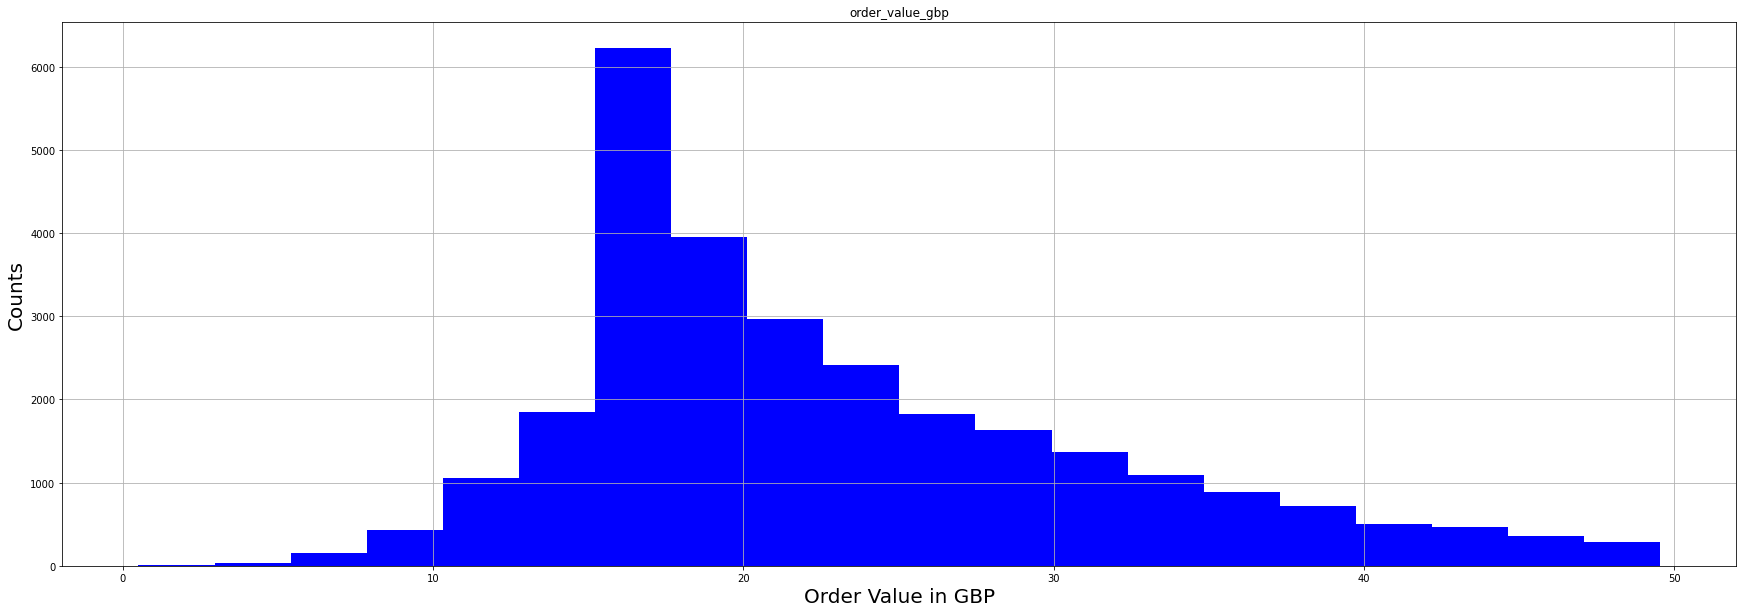

In [20]:
data.hist(column=['order_value_gbp'], bins=20, color='blue', figsize=(30, 10))

plt.ylabel('Counts', fontsize=20)
plt.xlabel('Order Value in GBP', fontsize=20)

Observation : majority of the orders are in the 10-40 GBP range

## Average Preparation Time by Monthday

Text(0, 0.5, 'Average Preparation Time in Seconds')

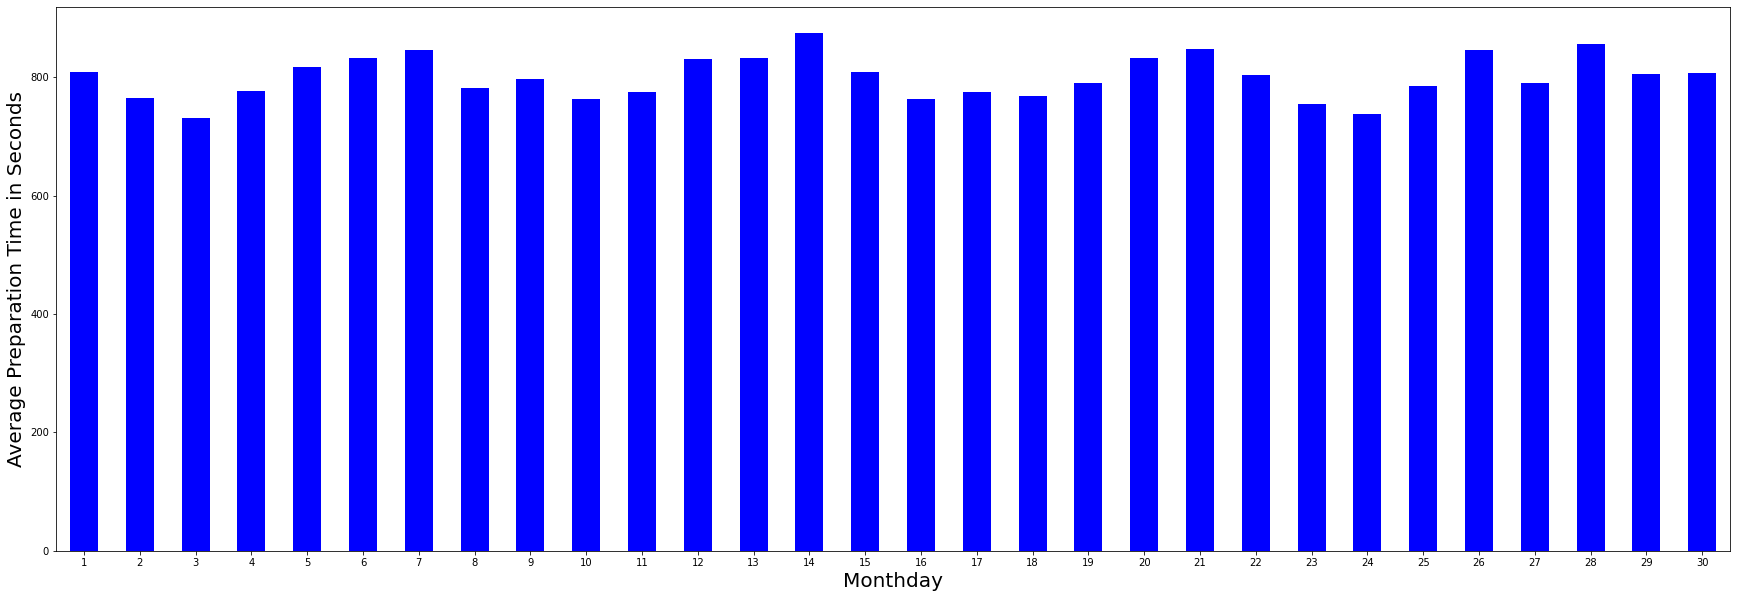

In [21]:
data.groupby([data.order_ack_monthday])\
  .prep_time_seconds.mean()\
  .plot(kind='bar', color='blue', figsize=(30, 10), rot=0)

plt.xlabel('Monthday', fontsize=20)
plt.ylabel('Average Preparation Time in Seconds', fontsize=20)

There is differences and a pattern in preparation time average 

## Average Preparation Time by Weekday

Text(0, 0.5, 'Average Preparation Time in Seconds')

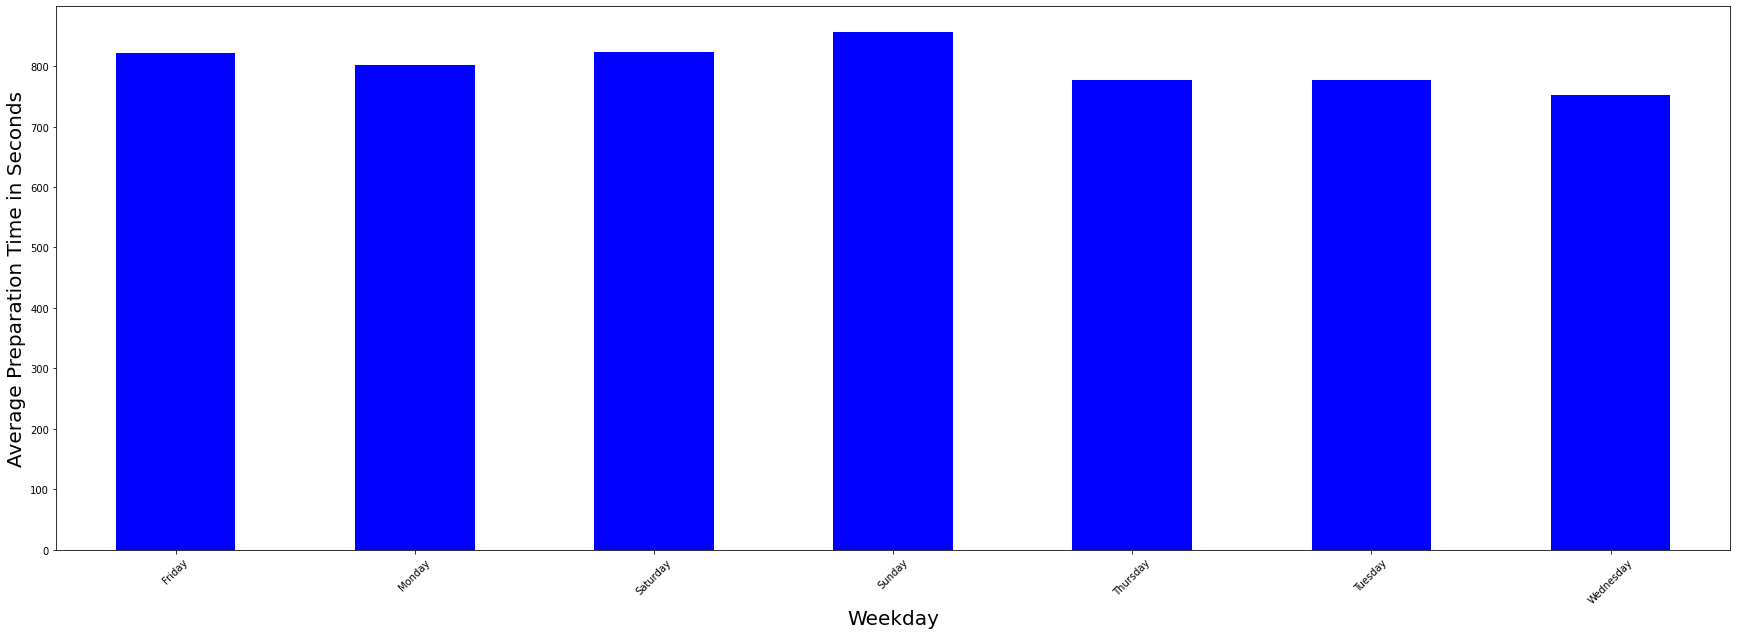

In [22]:
data.groupby([data.order_ack_dayname])\
  .prep_time_seconds.mean()\
  .plot(kind='bar', color='blue', figsize=(30, 10), rot=45)

plt.xlabel('Weekday', fontsize=20)
plt.ylabel('Average Preparation Time in Seconds', fontsize=20)

## Average Preparation Time by Hour

Text(0, 0.5, 'Average Preparation Time in Seconds')

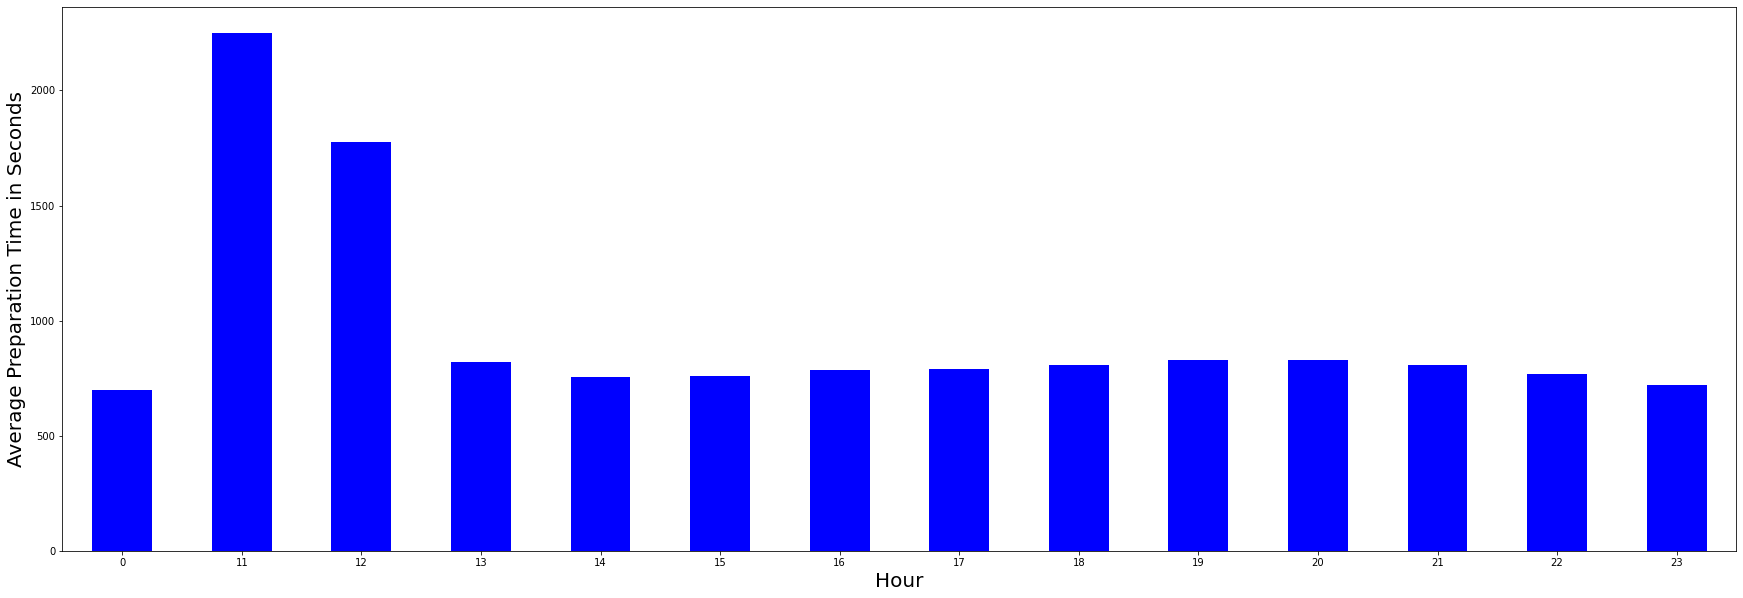

In [23]:
data.groupby([data.order_ack_hour])\
  .prep_time_seconds.mean()\
  .plot(kind='bar', color='blue', figsize=(30, 10), rot=0)

plt.xlabel('Hour', fontsize=20)
plt.ylabel('Average Preparation Time in Seconds', fontsize=20)

## Average Preparation Time by City

Text(0, 0.5, 'Average Preparation Time in Seconds')

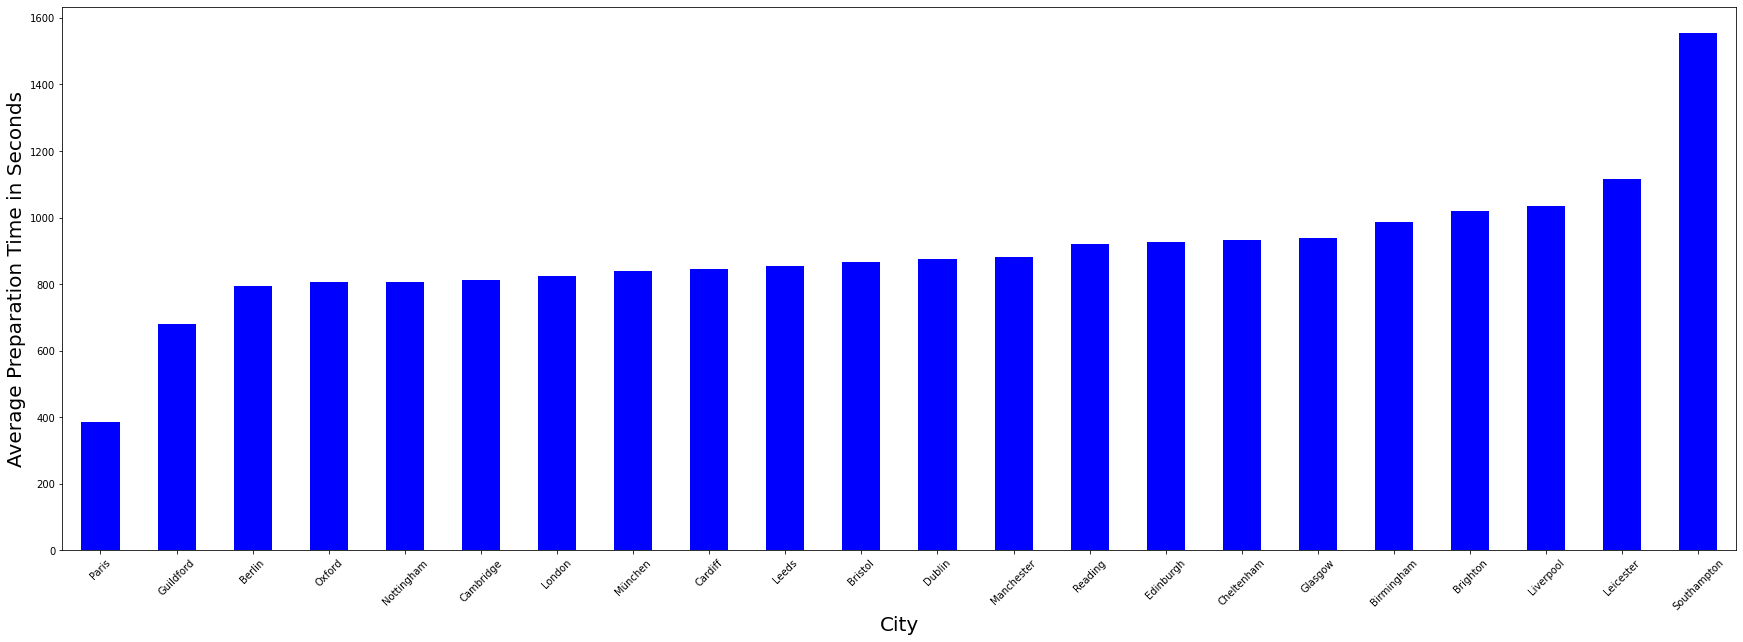

In [24]:
data.groupby([data.city])\
  .prep_time_seconds.mean()\
  .sort_values()\
  .plot(kind='bar', color='blue', figsize=(30, 10), rot=45)

plt.xlabel('City', fontsize=20)
plt.ylabel('Average Preparation Time in Seconds', fontsize=20)

## Average Preparation Time by Cuisine

Text(0, 0.5, 'Average Preparation Time in Seconds')

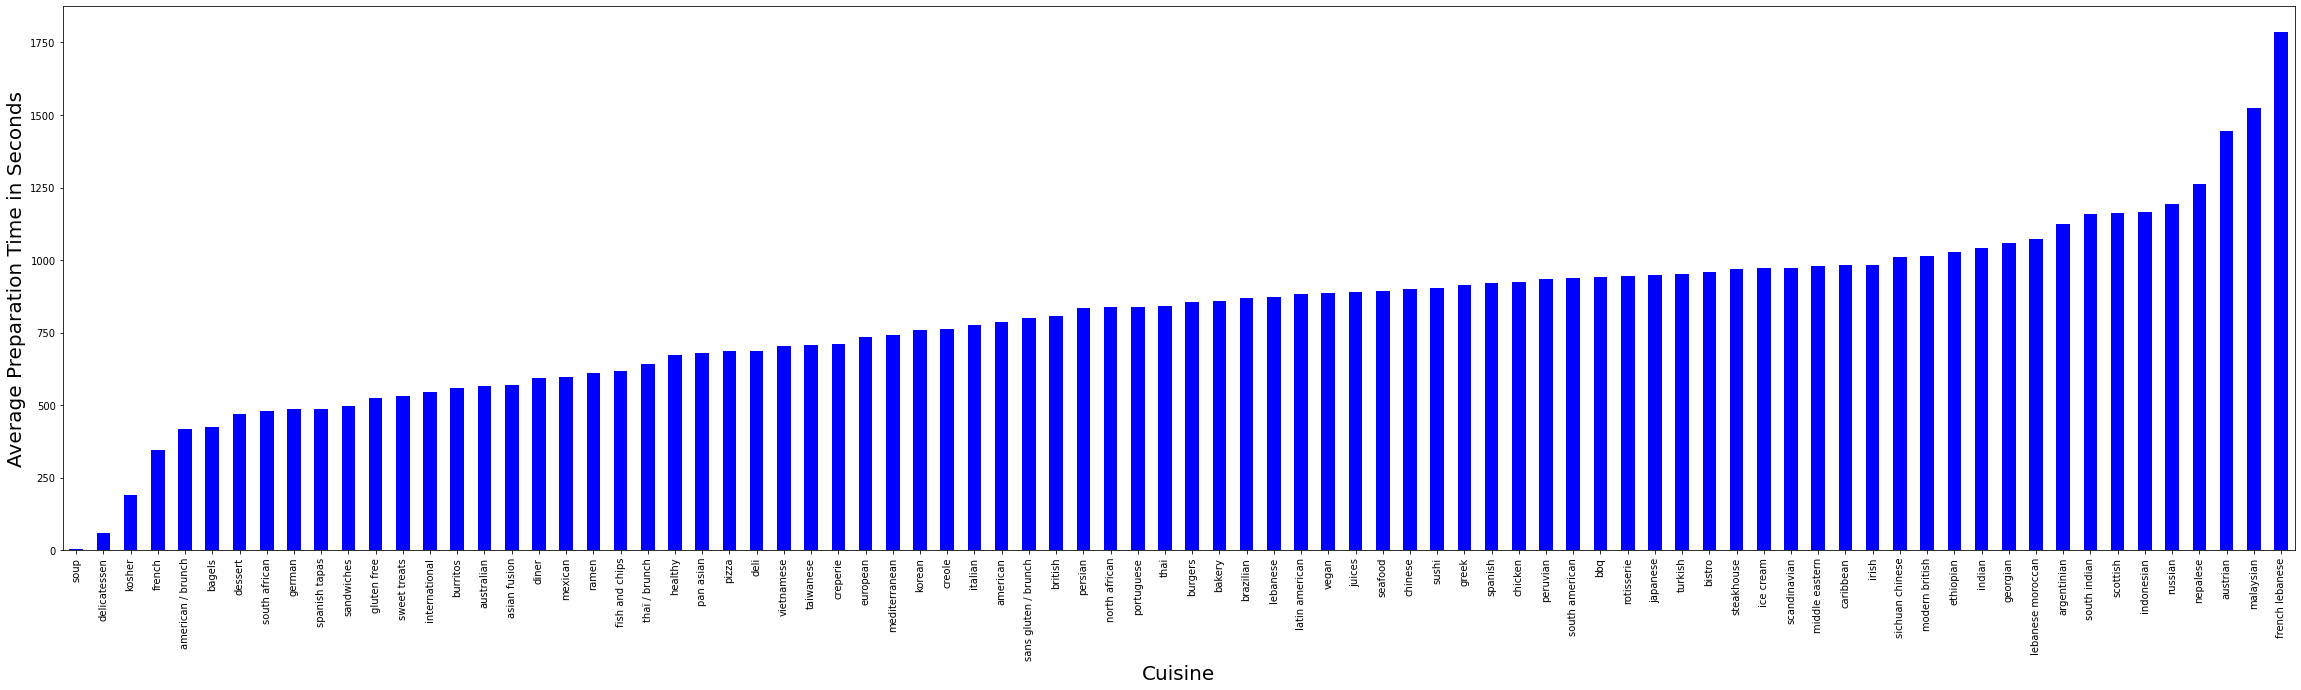

In [25]:
data.groupby([data.type_of_food])\
  .prep_time_seconds.mean()\
  .sort_values()\
  .plot(kind='bar', color='blue', figsize=(40, 10))

plt.xlabel('Cuisine', fontsize=20)
plt.ylabel('Average Preparation Time in Seconds', fontsize=20)

# Machine Learning

## Feature Engineering

To avoid overfitting, categorical features (city and type_of_food) are transformed into features that encode the mean food preparation time

In [26]:
def categorical_encode(column, labels):
  encoder = LeaveOneOutEncoder(sigma=0.01)
  encoded_column = encoder.fit_transform(X=column, y=labels)
  encoded_column.rename(columns={column.name: column.name + '_mean_prep_time'}, inplace=True)

  return pd.concat([column, encoded_column], axis=1)

In [27]:
data['city_mean_prep_time'] = categorical_encode(data['city'], data['prep_time_seconds']).iloc[:, 1]
data['type_of_food_mean_prep_time'] = categorical_encode(data['type_of_food'], data['prep_time_seconds']).iloc[:, 1]
data['restaurant_mean_prep_time'] = categorical_encode(data['restaurant_id'], data['prep_time_seconds']).iloc[:, 1]

cos/sin transformation for cyclical features (hours, weekday, and monthday)

In [28]:
def cyclical_encode(data, column, max_val):
  data[column + '_sin'] = np.sin(2 * np.pi * data[column]/max_val)
  data[column + '_cos'] = np.cos(2 * np.pi * data[column]/max_val)

  return data

In [29]:
data = cyclical_encode(data, 'order_ack_hour', 24)
data = cyclical_encode(data, 'order_ack_monthday', 31)
data = cyclical_encode(data, 'order_ack_weekday', 6)

Feature selection

In [30]:
label_name = 'prep_time_seconds'

In [31]:
feature_names = [
  # 'restaurant_id',
  'order_ack_monthday_cos',
  'order_ack_weekday_cos',
  'order_ack_hour_cos',
  'order_ack_monthday_sin',
  'order_ack_weekday_sin',
  'order_ack_hour_sin',
  'number_of_items',
  'order_value_gbp',
  'type_of_food_mean_prep_time',
  'city_mean_prep_time',
  'restaurant_mean_prep_time'
]

Adding mean preparation time as a feature improves the performance because it introduces the historical information to the modelling stage

## Splitting the Dataset

Split the dataset based on timestamp (instead of random split) to avoid feature leakage

In [32]:
split_date = datetime(2015, 6, 24)

train_data = data.loc[data['order_acknowledged_at'] <= split_date]
test_data = data.loc[data['order_acknowledged_at'] > split_date] # around 25% of the set

In [33]:
X_train = train_data[feature_names]
y_train = train_data[label_name]

In [34]:
X_test = test_data[feature_names]
y_test = test_data[label_name]

## Modelling

In [35]:
def grid_search(model, grid, X_train, y_train, cv):
  search = GridSearchCV(estimator=model, param_grid=grid, cv=cv, scoring='r2')
  grid_result = search.fit(X_train, y_train)

  print(f'Best training R2: {grid_result.best_score_} using {grid_result.best_params_}')

  return grid_result.best_estimator_

In [36]:
def evaluate_model(y_test, y_predicted):
  sns.regplot(y_test, y_predicted, scatter_kws={"color": "black"}, line_kws={"color": "red"})

  print('Test R2: ', r2_score(y_test, y_predicted))
  print('Test MAE: ', mean_absolute_error(y_test, y_predicted))
  print('Test MSE: ', mean_squared_error(y_test, y_predicted))

### Random Forest Regressor

In [37]:
model = RandomForestRegressor()

grid = {
  'n_estimators': [100],
  'max_features': ["auto", "sqrt", "log2"],
  "min_samples_split": [2, 4, 6]
}

# Search hyperparamters 
best_model = grid_search(model, grid, X_train, y_train, cv=3)

Best training R2: 0.12067639859678303 using {'max_features': 'sqrt', 'min_samples_split': 6, 'n_estimators': 100}


## Evaluation

Evaluate model on the test set

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Test R2:  0.2148764729206587
Test MAE:  321.31102917291827
Test MSE:  170782.95329769756


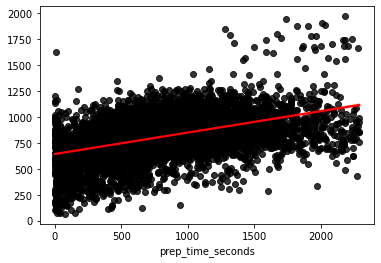

In [38]:
y_predicted = best_model.predict(X_test)
evaluate_model(y_test, y_predicted)

*   The model mispredicts the preparation time by 321 seconds
*   The model is able to explain 21% of variance in the preparation time

Cross-validation

In [39]:
rf_model = RandomForestRegressor(max_features='log2', min_samples_split=6, n_estimators=10)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
rf_scores = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=3)

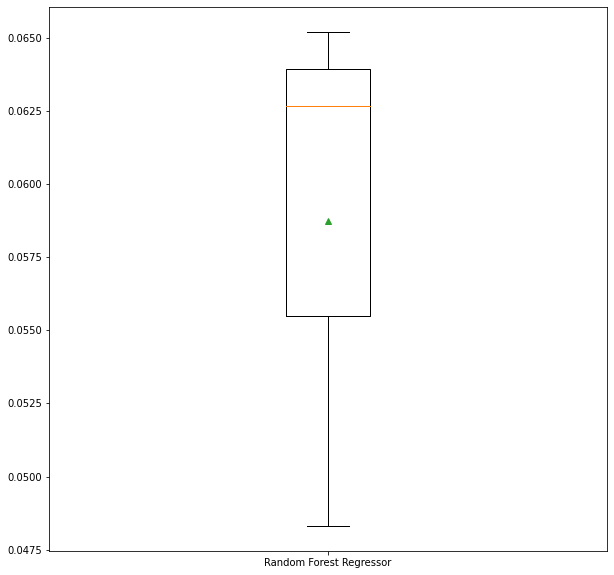

In [40]:
plt.figure(figsize=(10, 10))
plt.boxplot([rf_scores], labels=['Random Forest Regressor'], showmeans=True)
plt.show()

# Use-cases

The predicted food preparation time may be used to:
1.   Optimizing rider allocation by assigning the best rider to pick up the order  
2.   Estimate the total delivery time
